In [1]:
from datetime import datetime
import numpy as np             #for numerical computations like log,exp,sqrt etc
import pandas as pd            #for reading & storing data, pre-processing
import matplotlib.pylab as plt #for visualization
#for making sure matplotlib plots are generated in Jupyter notebook itself
%matplotlib inline             
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

In [2]:
path = "C:/Code_ML/Code/NoteBooks Cours TS - RNN-LSTM/notebook Modélisation ARIMA/AirPassengers.csv" #For local
dataset = pd.read_csv(path)
#Parse strings to datetime type
dataset['Month'] = pd.to_datetime(dataset['Month'],infer_datetime_format=True) #convert from string to datetime
indexedDataset = dataset.set_index(['Month'])
indexedDataset.head(5)

C:\Users\twentz\AppData\Local\Temp\ipykernel_8032\1125662150.py:4: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dataset['Month'] = pd.to_datetime(dataset['Month'],infer_datetime_format=True) #convert from string to datetime


,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


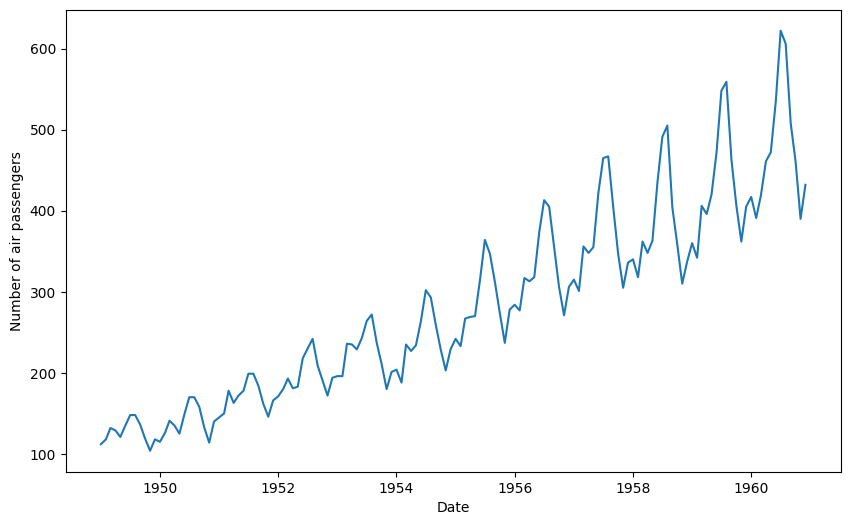

In [3]:
## plot graph
plt.xlabel('Date')
plt.ylabel('Number of air passengers')
plt.plot(indexedDataset)

# Calcul des statistiques roulantes sur la série temporelle

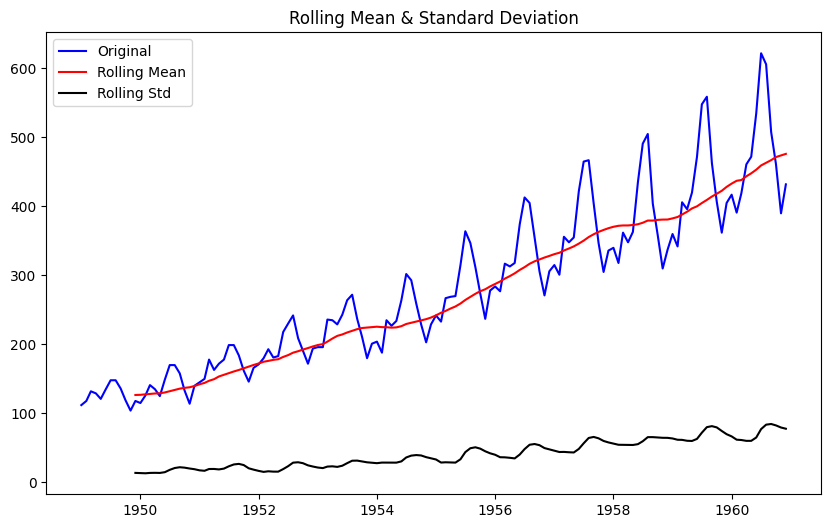

In [4]:
rolmean = indexedDataset.rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
rolstd = indexedDataset.rolling(window=12).std()

#Affichage
orig = plt.plot(indexedDataset, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

# Test de stationnarité de la série temporelle

In [5]:
#Perform Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(indexedDataset['#Passengers'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


#Comme la pvalue est superieure au seuil de significativité (0.05), il faut différencier la série
et afficher l'autocorrélation afin de déterminer le degré de dérivation nécessaire à la stationnarité

# Trouver le coefficient d du modèle ARIMA, le nombre de différentiations, et le coefficient q, ordre du MA

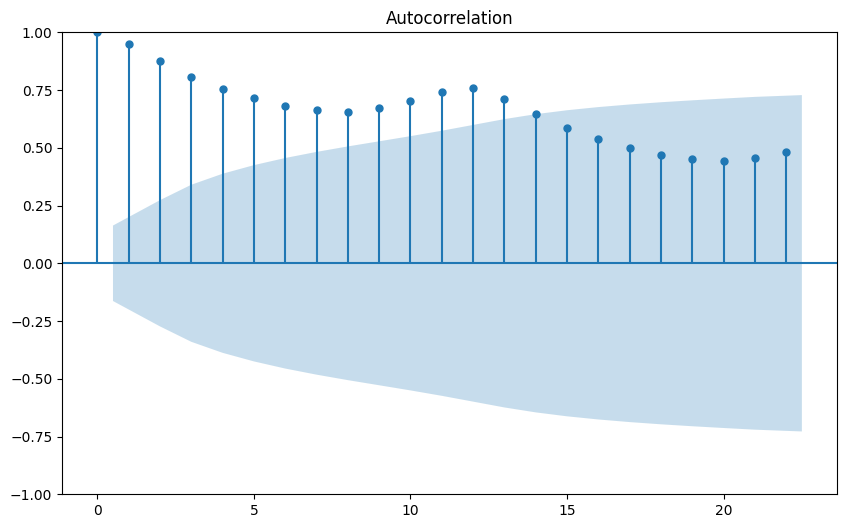

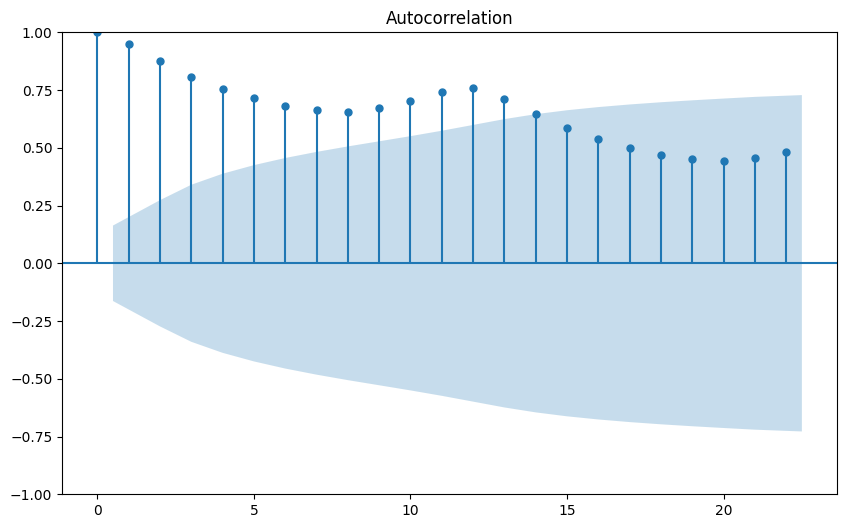

In [6]:
import statsmodels.tsa.stattools as stattools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot the ACF
plot_acf(indexedDataset['#Passengers'])

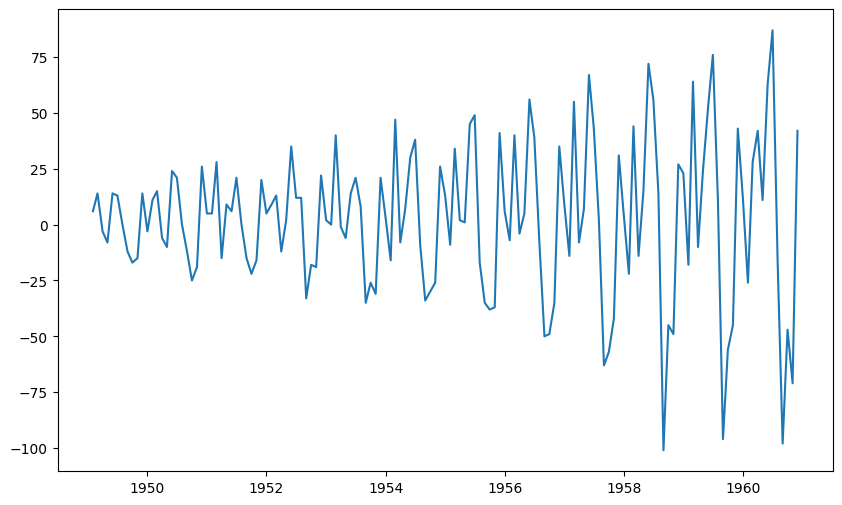

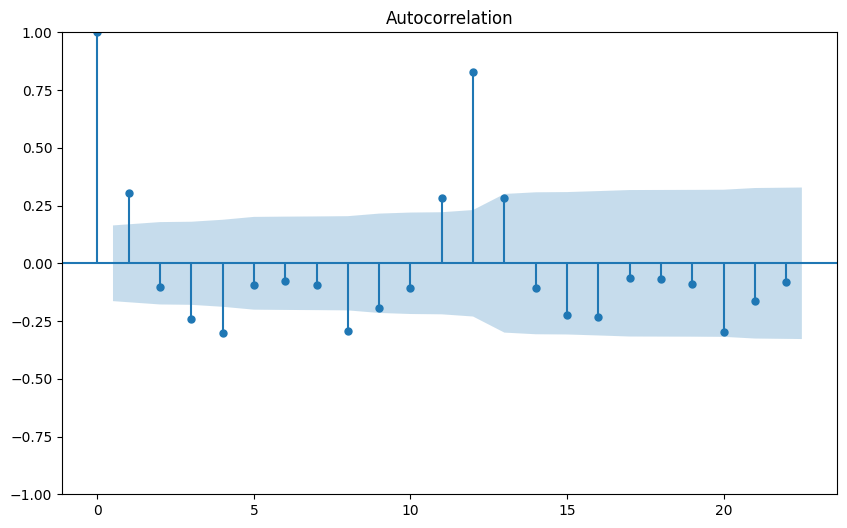

In [8]:
# 1st Differencing
plt.plot(indexedDataset['#Passengers'].diff())
plot_acf(indexedDataset['#Passengers'].diff().dropna())
plt.show()

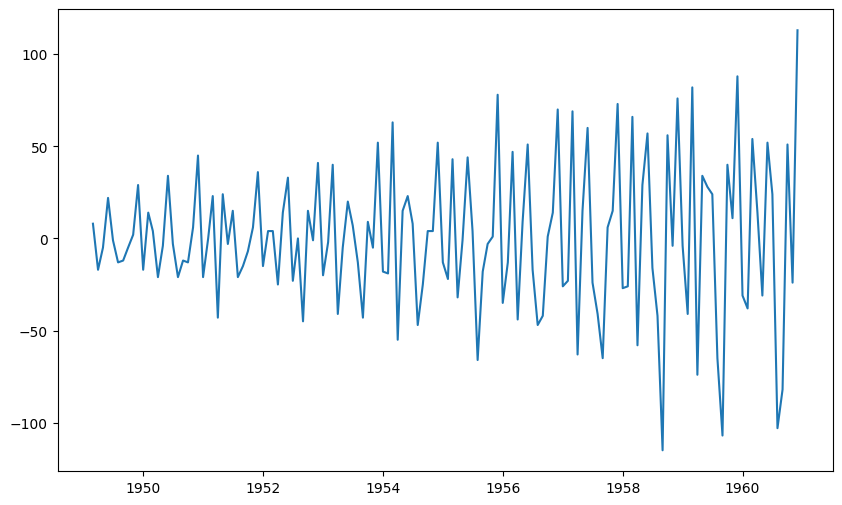

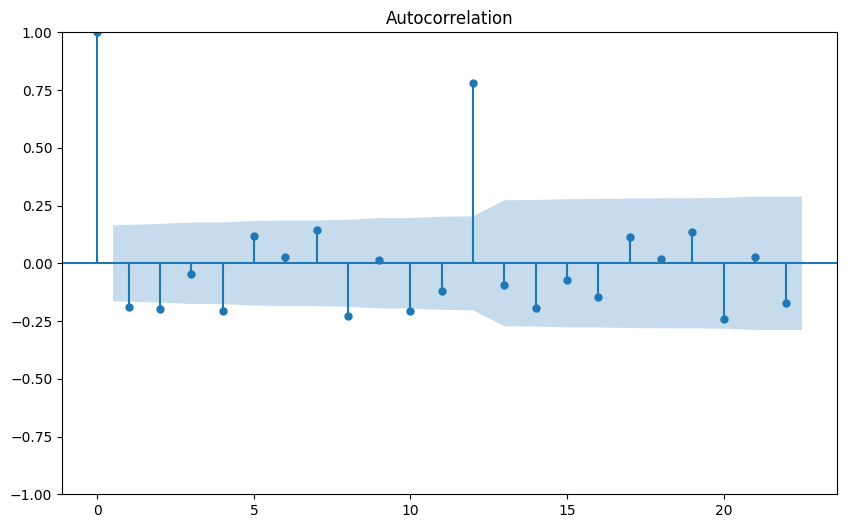

In [9]:
# 2nd Differencing
plt.plot(indexedDataset['#Passengers'].diff().diff())
plot_acf(indexedDataset['#Passengers'].diff().diff().dropna())
plt.show()

# Trouver le coefficient p, le terme d'Auto-Régression

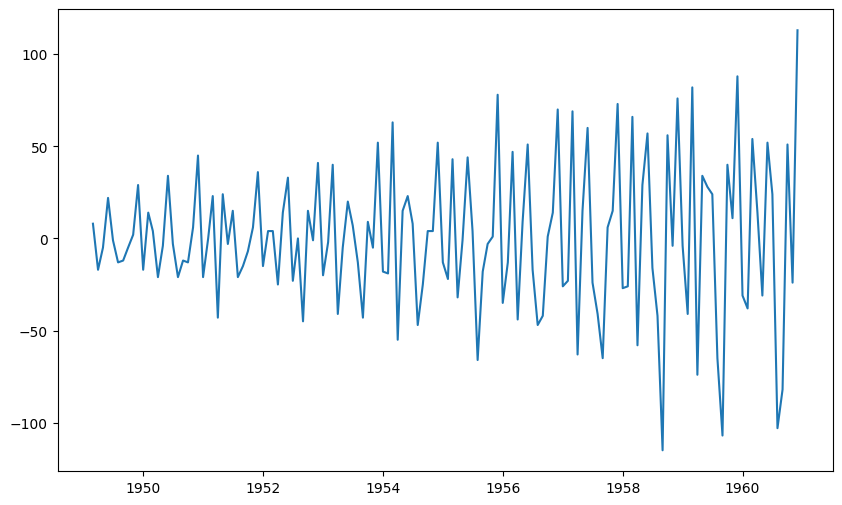

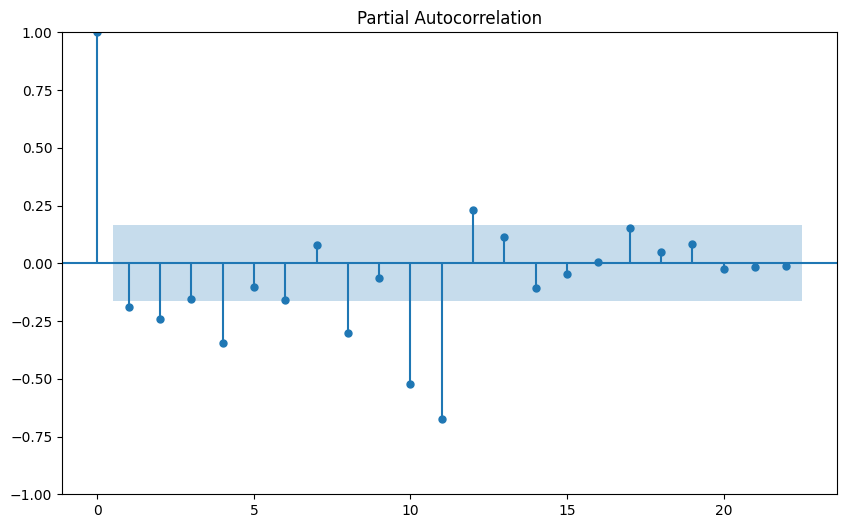

In [10]:
# PACF plot of 2st differenced series
plt.plot(indexedDataset['#Passengers'].diff().diff())
plot_pacf(indexedDataset['#Passengers'].diff().diff().dropna())
plt.show()

# Création du modèle ARIMA

In [14]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(indexedDataset['#Passengers'], order=(0,2,2))
results=model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(0, 2, 2)   Log Likelihood                -694.186
Date:                Wed, 05 Jul 2023   AIC                           1394.373
Time:                        09:48:11   BIC                           1403.240
Sample:                    01-01-1949   HQIC                          1397.976
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5927      1.677     -0.353      0.724      -3.879       2.694
ma.L2         -0.4067      0.710     -0.573      0.567      -1.798       0.985
sigma2      1000.6513   1734.482      0.577      0.5

C:\Code_ML\Librairies\Anaconda3\envs\Cours_Time_Series\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Code_ML\Librairies\Anaconda3\envs\Cours_Time_Series\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Code_ML\Librairies\Anaconda3\envs\Cours_Time_Series\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
# Plot residual errors
residuals = pd.DataFrame(results.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [ ]:
from statsmodels.graphics.tsaplots import plot_predict
# Actual vs Fitted


fig, ax = plt.subplots()
ax = indexedDataset['#Passengers'].loc['1957':].plot(ax=ax)
plot_predict(results, '1957', '1960', ax=ax)
plt.show()
